# Step 1 : Import libraries and setup

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Any
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

class WholesalerAnalyzer:
    """
    Analyzes customer spending patterns to investigate the wholesaler hypothesis.
    """
    
    def __init__(self, data_path):
        """Initialize the analyzer with data path"""
        self.data_path = data_path
        self.df = None
        self.stats = None
        
    def load_data(self):
        """Load the RFM customer segments data"""
        try:
            self.df = pd.read_csv(self.data_path)
            if 'Monetary' not in self.df.columns:
                raise ValueError("CSV must contain 'Monetary' column")
            print(f"Data loaded successfully: {self.df.shape}")
            return self.df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None
            
    def analyze_monetary_distribution(self) -> Dict[str, Any]:
        """
        Analyze the distribution of monetary values to investigate wholesaler hypothesis.
        """
        monetary_values = self.df['Monetary']
        
        # Calculate key statistics
        self.stats = {
            'total_customers': len(monetary_values),
            'mean_spending': monetary_values.mean(),
            'median_spending': monetary_values.median(),
            'std_spending': monetary_values.std(),
            'min_spending': monetary_values.min(),
            'max_spending': monetary_values.max(),
            'skewness': monetary_values.skew(),
            'percentiles': {
                '25th': monetary_values.quantile(0.25),
                '75th': monetary_values.quantile(0.75),
                '90th': monetary_values.quantile(0.90),
                '95th': monetary_values.quantile(0.95),
                '99th': monetary_values.quantile(0.99)
            }
        }
        
        # Wholesaler analysis (top 5% spenders)
        wholesale_threshold = self.stats['percentiles']['95th']
        potential_wholesalers = monetary_values[monetary_values >= wholesale_threshold]
        
        self.stats['wholesale_analysis'] = {
            'threshold_95th': wholesale_threshold,
            'potential_wholesaler_count': len(potential_wholesalers),
            'potential_wholesaler_percentage': (len(potential_wholesalers) / len(monetary_values)) * 100,
            'wholesaler_revenue_share': (potential_wholesalers.sum() / monetary_values.sum()) * 100
        }
        
        return self.stats
    
    def create_monetary_histogram(self, bins=50, figsize=(15, 10)):
        """
        Create comprehensive histogram to visualize monetary distribution and investigate wholesaler hypothesis.
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Customer Monetary Value Distribution Analysis\n(Investigating Wholesaler Hypothesis)', 
                     fontsize=16, fontweight='bold')
        
        monetary_values = self.df['Monetary']
        
        # 1. Standard histogram with key statistics
        axes[0, 0].hist(monetary_values, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Distribution of Customer Spending')
        axes[0, 0].set_xlabel('Total Spending (£)')
        axes[0, 0].set_ylabel('Number of Customers')
        axes[0, 0].axvline(self.stats['mean_spending'], color='red', linestyle='--', 
                          label=f'Mean: £{self.stats["mean_spending"]:.0f}')
        axes[0, 0].axvline(self.stats['median_spending'], color='orange', linestyle='--', 
                          label=f'Median: £{self.stats["median_spending"]:.0f}')
        axes[0, 0].axvline(self.stats['percentiles']['95th'], color='purple', linestyle='--', 
                          label=f'95th percentile: £{self.stats["percentiles"]["95th"]:.0f}')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Log scale histogram (to better see distribution shape)
        log_monetary = np.log10(monetary_values + 1)  # Add 1 to avoid log(0)
        axes[0, 1].hist(log_monetary, bins=bins, color='lightgreen', alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Distribution (Log10 Scale)')
        axes[0, 1].set_xlabel('Log10(Total Spending + 1)')
        axes[0, 1].set_ylabel('Number of Customers')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Zoomed histogram (exclude top 1% to see main distribution)
        percentile_99 = self.stats['percentiles']['99th']
        main_distribution = monetary_values[monetary_values <= percentile_99]
        axes[1, 0].hist(main_distribution, bins=bins, color='gold', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Distribution (Excluding Top 1% Spenders)')
        axes[1, 0].set_xlabel('Total Spending (£)')
        axes[1, 0].set_ylabel('Number of Customers')
        axes[1, 0].axvline(main_distribution.mean(), color='red', linestyle='--', 
                          label=f'Mean (excl. top 1%): £{main_distribution.mean():.0f}')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Box plot to show outliers
        box = axes[1, 1].boxplot(monetary_values, vert=True, patch_artist=True,
                                boxprops=dict(facecolor='lightcoral', alpha=0.7))
        axes[1, 1].set_title('Box Plot of Customer Spending\n(Shows Outliers)')
        axes[1, 1].set_ylabel('Total Spending (£)')
        axes[1, 1].set_xlabel('All Customers')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def identify_customer_segments(self):
        """
        Identify potential retail vs wholesale customers based on spending patterns.
        """
        # Calculate percentile thresholds
        p90 = self.df['Monetary'].quantile(0.90)
        p95 = self.df['Monetary'].quantile(0.95)
        
        # Create customer segments
        def categorize_customer(monetary_value):
            if monetary_value >= p95:
                return 'High-Value Wholesale'
            elif monetary_value >= p90:
                return 'Potential Wholesale'
            else:
                return 'Retail Customer'
        
        # Apply segmentation
        self.df['Customer_Type'] = self.df['Monetary'].apply(categorize_customer)
        return self.df
    
    def generate_insights_summary(self):
        """
        Generate text summary of wholesaler hypothesis findings.
        """
        if not self.stats:
            self.analyze_monetary_distribution()
            
        summary = f"""
WHOLESALER HYPOTHESIS INVESTIGATION SUMMARY
===========================================

Dataset Overview:
- Total Customers Analyzed: {self.stats['total_customers']:,}
- Average Customer Spending: £{self.stats['mean_spending']:.2f}
- Median Customer Spending: £{self.stats['median_spending']:.2f}
- Distribution Skewness: {self.stats['skewness']:.2f} (Positive = Right-skewed)

Key Findings:
1. Distribution Shape: {'Highly right-skewed' if self.stats['skewness'] > 2 else 'Moderately skewed' if self.stats['skewness'] > 1 else 'Relatively normal'}
2. Mean vs Median Gap: £{self.stats['mean_spending'] - self.stats['median_spending']:.2f}
   (Large gap indicates presence of high-spending outliers)

Potential Wholesaler Analysis:
- 95th Percentile Threshold: £{self.stats['wholesale_analysis']['threshold_95th']:.2f}
- Potential Wholesalers (Top 5%): {self.stats['wholesale_analysis']['potential_wholesaler_count']} customers
- Revenue Share of Top 5%: {self.stats['wholesale_analysis']['wholesaler_revenue_share']:.1f}%

Interpretation:
{'Strong evidence of two distinct customer groups - likely retail vs wholesale customers.' if self.stats['wholesale_analysis']['wholesaler_revenue_share'] > 30 else 'Some evidence of high-value customers, but distribution may not clearly show wholesale segment.'}
{'The high skewness and significant revenue concentration suggest wholesale presence.' if self.stats['skewness'] > 2 else 'Distribution suggests more uniform customer base.'}
        """
        
        print(summary)
        return summary

# Step 2 : Initialize analyzer and load data

In [9]:
analyzer = WholesalerAnalyzer("../results/phase_3/rfm_customer_segments.csv")
df = analyzer.load_data()

# Display basic info about the dataset
if df is not None:
    print("\nDataset Info:")
    print(df.head())
    print(f"\nMonetary column statistics:")
    print(df['Monetary'].describe())

Data loaded successfully: (5861, 9)

Dataset Info:
   Customer ID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0        12346      326         12  77556.46        2        5        5   
1        12347        2          8   4921.53        5        4        5   
2        12348       75          5   1658.40        3        4        4   
3        12349       19          3   3678.69        5        3        5   
4        12350      310          1    294.40        2        1        2   

   RFM_Segment            Segment  
0          255  At-Risk Customers  
1          545          Champions  
2          344    Loyal Customers  
3          535                NaN  
4          212        Hibernating  

Monetary column statistics:
count      5861.000000
mean       2913.065381
std       14300.687269
min           2.950000
25%         338.130000
50%         854.990000
75%        2237.120000
max      580987.040000
Name: Monetary, dtype: float64


# Step 3 : Analyze monetary distribution

In [10]:
if df is not None:
    print("Analyzing monetary distribution...")
    stats = analyzer.analyze_monetary_distribution()
    
    print(f"\nKey Statistics:")
    print(f"Mean spending: £{stats['mean_spending']:.2f}")
    print(f"Median spending: £{stats['median_spending']:.2f}")
    print(f"Standard deviation: £{stats['std_spending']:.2f}")
    print(f"Skewness: {stats['skewness']:.2f}")
    print(f"95th percentile threshold: £{stats['percentiles']['95th']:.2f}")
    print(f"Potential wholesalers: {stats['wholesale_analysis']['potential_wholesaler_count']} ({stats['wholesale_analysis']['potential_wholesaler_percentage']:.1f}%)")
    print(f"Wholesaler revenue share: {stats['wholesale_analysis']['wholesaler_revenue_share']:.1f}%")


Analyzing monetary distribution...

Key Statistics:
Mean spending: £2913.07
Median spending: £854.99
Standard deviation: £14300.69
Skewness: 25.34
95th percentile threshold: £9266.00
Potential wholesalers: 294 (5.0%)
Wholesaler revenue share: 52.0%


# Step 4 : Creation of comprehensive histogram visualization


Creating monetary distribution histograms...


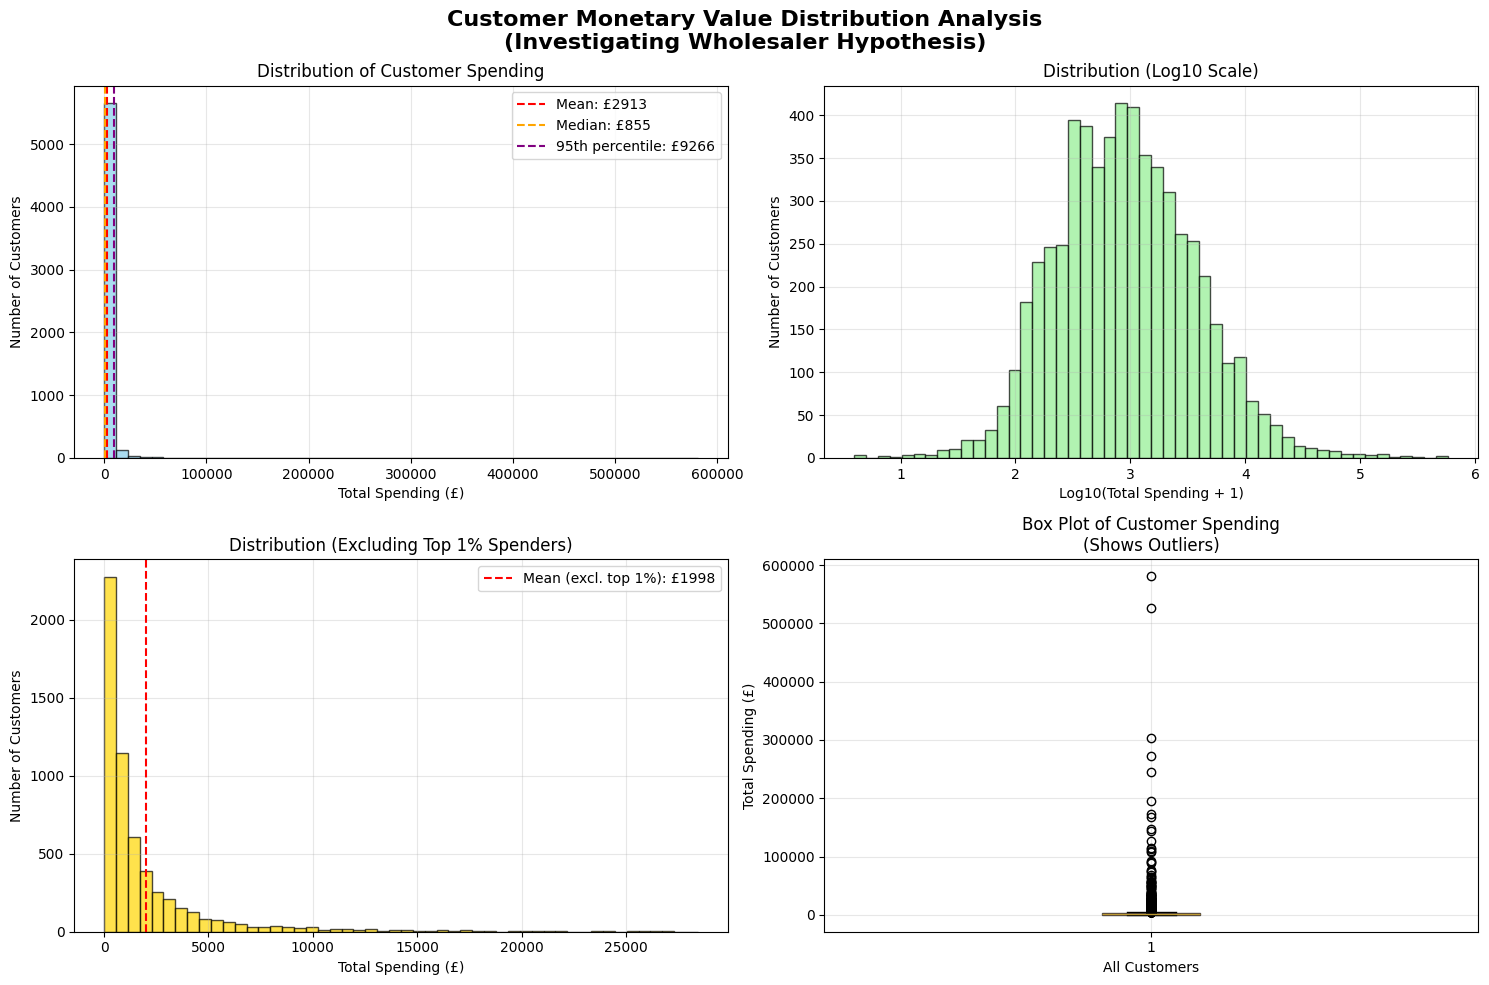

In [11]:
if df is not None:
    print("\nCreating monetary distribution histograms...")
    fig = analyzer.create_monetary_histogram()

# Step 5 : Identify the customer segments

In [5]:
if df is not None:
    print("Identifying customer segments...")
    segmented_df = analyzer.identify_customer_segments()
    
    # Show segment distribution
    segment_counts = segmented_df['Customer_Type'].value_counts()
    segment_percentages = segmented_df['Customer_Type'].value_counts(normalize=True) * 100
    
    print("\nCustomer Segment Distribution:")
    for segment in segment_counts.index:
        count = segment_counts[segment]
        percentage = segment_percentages[segment]
        print(f"{segment}: {count} customers ({percentage:.1f}%)")

Identifying customer segments...

Customer Segment Distribution:
Retail Customer: 5274 customers (90.0%)
High-Value Wholesale: 294 customers (5.0%)
Potential Wholesale: 293 customers (5.0%)


# Step 6 : Generating an insight summary

In [6]:
if df is not None:
    print("Generating insights summary...")
    summary = analyzer.generate_insights_summary()

Generating insights summary...

WHOLESALER HYPOTHESIS INVESTIGATION SUMMARY

Dataset Overview:
- Total Customers Analyzed: 5,861
- Average Customer Spending: £2913.07
- Median Customer Spending: £854.99
- Distribution Skewness: 25.34 (Positive = Right-skewed)

Key Findings:
1. Distribution Shape: Highly right-skewed
2. Mean vs Median Gap: £2058.08
   (Large gap indicates presence of high-spending outliers)

Potential Wholesaler Analysis:
- 95th Percentile Threshold: £9266.00
- Potential Wholesalers (Top 5%): 294 customers
- Revenue Share of Top 5%: 52.0%

Interpretation:
Strong evidence of two distinct customer groups - likely retail vs wholesale customers.
The high skewness and significant revenue concentration suggest wholesale presence.
        


# Additional Segment comparison

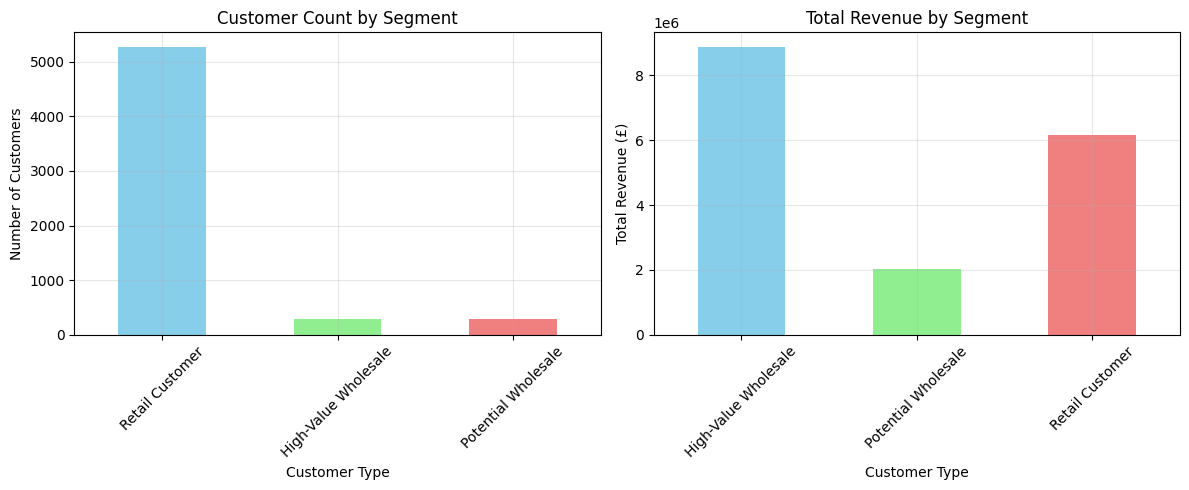


Revenue Analysis by Segment:
High-Value Wholesale: £8,884,048.10 (52.0% of total revenue)
Potential Wholesale: £2,029,487.90 (11.9% of total revenue)
Retail Customer: £6,159,940.19 (36.1% of total revenue)


In [7]:
if df is not None:
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Customer count by segment
    plt.subplot(1, 2, 1)
    segment_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('Customer Count by Segment')
    plt.xlabel('Customer Type')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Revenue by segment
    plt.subplot(1, 2, 2)
    revenue_by_segment = segmented_df.groupby('Customer_Type')['Monetary'].sum()
    revenue_by_segment.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('Total Revenue by Segment')
    plt.xlabel('Customer Type')
    plt.ylabel('Total Revenue (£)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nRevenue Analysis by Segment:")
    for segment in revenue_by_segment.index:
        revenue = revenue_by_segment[segment]
        percentage = (revenue / segmented_df['Monetary'].sum()) * 100
        print(f"{segment}: £{revenue:,.2f} ({percentage:.1f}% of total revenue)")